In [1]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plot
import math
from matplotlib import rc
from pylab import rcParams

import pandas as pd
import numpy as numpy
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='jpeg'
# !jupyter nbextension enable --py widgetsnbextension

# sns.set(style='whitegrid', palette='muted', font_scale=1.2)
# HAPPY_COLORS_PALETTE = ['#01BEFE', '#FFDD00', '#FF7D00', '#FF006D', '#ADFF02', '#8F00FF']
# sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
# rcParams['figure.figsize'] = 12, 8
# tqdm.pandas()
# pl.seed_everything(42)

### Import dataset

In [3]:
df = pd.read_csv('../datasets/household_power_consumption_v3_drop.txt', parse_dates={'datetime' : ['date','time']}, index_col='datetime', sep=';', usecols=[1,2,3,4,5,6,7,8,9,11,12,13])
df.head(5)

,global_active_power,global_reactive_power,voltage,global_intensity,kitchen,laundry_room,thermal_utilities,day,month,year
datetime,,,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,16,12,2006
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,16,12,2006
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,16,12,2006
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,16,12,2006
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,16,12,2006


In [4]:
cols = ['global_reactive_power', 'voltage', 'global_intensity', 'kitchen', 'laundry_room', 'thermal_utilities', 'day', 'month', 'year', 'global_active_power']
features_df = df[cols]
features_df.head()

,global_reactive_power,voltage,global_intensity,kitchen,laundry_room,thermal_utilities,day,month,year,global_active_power
datetime,,,,,,,,,,
2006-12-16 17:24:00,0.418,234.84,18.4,0.0,1.0,17.0,16,12,2006,4.216
2006-12-16 17:25:00,0.436,233.63,23.0,0.0,1.0,16.0,16,12,2006,5.360
2006-12-16 17:26:00,0.498,233.29,23.0,0.0,2.0,17.0,16,12,2006,5.374
2006-12-16 17:27:00,0.502,233.74,23.0,0.0,1.0,17.0,16,12,2006,5.388
2006-12-16 17:28:00,0.528,235.68,15.8,0.0,1.0,17.0,16,12,2006,3.666


### Preprocessing 

Split - Train ```.6```, Validation ```.2```, Test ```.2```

In [5]:
train_size = int(len(features_df) * .6) # 60% training
val_size = int((len(features_df) - train_size) * .5) + train_size # 20% validation and test
train_size, val_size

(1229568, 1639424)

In [6]:
train_df, val_df, test_df = features_df[:train_size], features_df[train_size:val_size], features_df[val_size:]
print(train_df.shape, val_df.shape, test_df.shape)

(1229568, 10) (409856, 10) (409856, 10)


__Normalization__

In [7]:
# scalling data only using train df
scaler = MinMaxScaler(feature_range=(-1,1))
scaler = scaler.fit(train_df)

In [8]:
train_df = pd.DataFrame(
    scaler.transform(train_df), 
    index=train_df.index, 
    columns=train_df.columns)
train_df.head(3)

,global_reactive_power,voltage,global_intensity,kitchen,laundry_room,thermal_utilities,day,month,year,global_active_power
datetime,,,,,,,,,,
2006-12-16 17:24:00,-0.398561,-0.254516,-0.244813,-1.0,-0.974359,0.096774,0.0,1.0,-1.0,-0.250407
2006-12-16 17:25:00,-0.372662,-0.333990,-0.053942,-1.0,-0.974359,0.032258,0.0,1.0,-1.0,-0.043274
2006-12-16 17:26:00,-0.283453,-0.356322,-0.053942,-1.0,-0.948718,0.096774,0.0,1.0,-1.0,-0.040739


In [9]:
test_df = pd.DataFrame(
    scaler.transform(test_df), 
    index=test_df.index, 
    columns=test_df.columns)
test_df.head(3)

,global_reactive_power,voltage,global_intensity,kitchen,laundry_room,thermal_utilities,day,month,year,global_active_power
datetime,,,,,,,,,,
2010-02-05 04:29:00,-0.516547,0.559278,-0.900415,-1.0,-0.948718,-0.935484,-0.733333,-0.818182,1.666667,-0.915263
2010-02-05 04:30:00,-0.522302,0.552053,-0.900415,-1.0,-0.974359,-0.935484,-0.733333,-0.818182,1.666667,-0.918160
2010-02-05 04:31:00,-0.516547,0.598686,-0.900415,-1.0,-0.974359,-1.000000,-0.733333,-0.818182,1.666667,-0.918160


In [10]:
val_df = pd.DataFrame(
    scaler.transform(val_df), 
    index=val_df.index, 
    columns=val_df.columns)
val_df.head(3)

,global_reactive_power,voltage,global_intensity,kitchen,laundry_room,thermal_utilities,day,month,year,global_active_power
datetime,,,,,,,,,,
2009-04-21 11:11:00,-0.458993,-0.120525,-0.659751,-1.0,-1.0,0.16129,0.333333,-0.454545,1.0,-0.677711
2009-04-21 11:12:00,-0.159712,-0.129064,-0.618257,-1.0,-1.0,0.16129,0.333333,-0.454545,1.0,-0.628825
2009-04-21 11:13:00,-0.165468,-0.201314,-0.618257,-1.0,-1.0,0.16129,0.333333,-0.454545,1.0,-0.637154


__Create sequence__

In [11]:
def create_sequences(input_data: pd.DataFrame, target_column, sequence_length, offset = 1):
    sequences = []
    data_size = len(input_data)
    
    for i in range(data_size - sequence_length):
        sequence = input_data[i:i+sequence_length]
        
        label_poisition = i+sequence_length
        label = input_data.iloc[label_poisition:label_poisition+offset][target_column]
        
        sequences.append((sequence, label))
        
    return sequences

In [12]:
num_seq = 60 # 60 minutes
offset = 1
train_sequences = create_sequences(train_df, 'global_active_power', num_seq, offset)
val_sequences = create_sequences(val_df, 'global_active_power', num_seq, offset)
test_sequences = create_sequences(test_df, 'global_active_power', num_seq, offset)

In [13]:
len(train_sequences), len(val_sequences), len(test_sequences)

(1229508, 409796, 409796)

### Create dataset

In [14]:
class PCDataset(Dataset):
    def __init__(self, sequences):
        # super().__init__()
        self.sequences = sequences
    def __len__(self):
        return len(self.sequences)
    def __getitem__(self, index):
        sequence, label = self.sequences[index]
        return dict(
            sequence = torch.Tensor(sequence.to_numpy()).to(device='cuda') if torch.cuda.is_available() else torch.Tensor(sequence.to_numpy()), # put to cuda device if available
            label = torch.Tensor(label).float().to(device='cuda') if torch.cuda.is_available() else torch.Tensor(label).float() # put to cuda device if available
        )
        

Pytorch lightning data module

In [15]:
class PCDataModule():
    def __init__(self, train_sequences, test_sequences, batch_size=8):
        self.train_sequences = train_sequences
        self.val_sequences = val_sequences
        self.test_sequences = test_sequences
        self.batch_size = batch_size
        print('batch size', self.batch_size)
        
    def setup(self, stage=None):
        self.train_dataset = PCDataset(self.train_sequences)
        self.val_dataset = PCDataset(self.val_sequences)
        self.test_dataset = PCDataset(self.test_sequences)
        
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            # num_workers=2
        )
        
    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            # num_workers=2
        )
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            # num_workers=2
        )

Setup data module

In [16]:
num_epoch = 5
batch_size = 64

data_module = PCDataModule(train_sequences, test_sequences, batch_size)
data_module.setup()

batch size 64


In [17]:
val = data_module.val_dataloader()
for v in val:
    print(v['sequence'].shape)
    print(v['sequence'].transpose(1,2).shape)
    print(v['label'].shape)
    
    break

torch.Size([64, 60, 10])
torch.Size([64, 10, 60])
torch.Size([64, 1])


### Model building

Pytorch model

In [18]:
class CNNLSTM(nn.Module):
    def __init__(self, n_features, n_hidden=64, kernel_size=2, lstm_input_size=None):
        super(CNNLSTM, self).__init__()
        self.n_hidden = n_hidden
        
        ### CNN
        # convolution layer
        self.conv1 = nn.Conv1d(in_channels=n_features, out_channels=n_hidden, kernel_size=kernel_size)
        self.conv2 = nn.Conv1d(in_channels=n_hidden, out_channels=n_hidden, kernel_size=kernel_size)
        
        # pooling layer
        self.pool1 = nn.MaxPool1d(kernel_size=kernel_size, stride=2)
        self.pool2 = nn.MaxPool1d(kernel_size=kernel_size, stride=2)
        
        
        ### LSTM 
        if lstm_input_size is not None:
            self.lstm = nn.LSTM(
                input_size=lstm_input_size,
                hidden_size=n_hidden,
                batch_first=True,
                num_layers=1,
                dropout=0.2
            )
        else:
            self.lstm = None
        # self.lstm = None
        
        # linear
        self.lin1 = nn.Linear(self.n_hidden, 32)
        self.lin2 = nn.Linear(32, 1)
        
        self.initialized = False
    
    def forward(self, x):
        
        # print("[in model] input shape before", x.shape)
        x = x.transpose(1,2)
        # print("[in model] input shape before", x.shape)
        
        # conv1
        x = self.conv1(x)
        x = x.relu()
        x = self.pool1(x)
        
        # print('sofarsogud')
        
        # conv2
        x = self.conv2(x)
        x = x.relu()
        x = self.pool2(x)
        
        
        # print("size x", x.size()) # batch, feature, sequence
        
        # lstm input
        # (batch, seq, feature), then transpose
        x = x.transpose(1,2)
        # print("size xT", x.size())
        
        
        # Dynamically create lstm + linear layers if not already created
        if not self.initialized:
            n_size = x.size(2)
            print("size", n_size)
            self.lstm = nn.LSTM(
                input_size=n_size, #input feature
                hidden_size=self.n_hidden,
                batch_first=True,
                num_layers=1,
                dropout=0.2
            ).to(x.device)
            
            # self.lin1 = nn.Linear(self.n_hidden, 32).to(x.device)
            # self.lin2 = nn.Linear(32, 1).to(x.device)
            self.initialized = True
        
        # LSTM
        self.lstm.flatten_parameters()
        _, (hidden, _) = self.lstm(x) # take the hidden state
        x = hidden[-1] # take the last layer, which contains the features
        
        # Linear layers
        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)
        
        return x

Pytorch lightning predictor wrapper

In [19]:
model = CNNLSTM(n_features=df.shape[1])
model.to(torch.device('cuda'))
out = None

for d in data_module.train_dataloader():
    sequence = d['sequence']
    label = d['label']
    # for batch_seq, batch_label in enumerate(sequence, label):  
    #     print(batch_seq.shape)
    #     print(batch_label.shape)
    #     break
    
    # print(out.shape)
    
    break

# print(out)

In [20]:
for data in data_module.train_dataloader():
    print(data['sequence'].shape)
    print(data['label'].shape)
    break

torch.Size([64, 60, 10])
torch.Size([64, 1])


In [21]:
model = CNNLSTM(n_features=df.shape[1]).to(torch.device('cuda'))
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()
criterion = nn.MSELoss()
device = torch.device('cuda')
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 5

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0

    for data in train_loader:
        sequences = data['sequence']
        labels = data['label']
        # # Forward pass
        # print("input seq shape", sequences.shape)
        # print("label", labels.shape)
        outputs = model(sequences)
        # print("output shape", outputs.shape)
        # print("output", outputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        # print('loss', total_loss)
        # break

    # Calculate average loss over the epoch
    # avg_train_loss = total_loss
    avg_train_loss = total_loss / len(train_loader)

    # break
    # Validation
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():
        for data in val_loader:
            sequences = data['sequence']
            labels = data['label']
            sequences, labels = sequences.to(device), labels.to(device)
            
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
            # break

    avg_val_loss = total_val_loss / len(val_loader)
    # avg_val_loss = total_val_loss

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    break


size 64


c:\Users\sclab\anaconda3\envs\xai\lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [1/5], Train Loss: 0.0113, Val Loss: 0.0148


In [22]:
avg_train_loss

0.011325839793868073

### Viz Test Dataset

In [ ]:
test_loader = data_module.test_dataloader()

outputs_seq = []
labels_seq = []
for data in test_loader:
    sequences = data['sequence']
    labels = data['label']
    
    outputs = model(sequences).detach()
    outputs_seq.append(outputs)
    labels_seq.append(labels)
    

# print(outputs_seq.shape)
# print(labels_seq.shape)
    

In [89]:
preds = []
y = []
for output_seq in outputs_seq:
    for output in output_seq:
        preds.append(output.item())
        
for label_seq in labels_seq:
    for label in label_seq:
        y.append(label.item())

In [90]:
test_df.shape[0] - 60, len(y)


(409796, 409796)

In [91]:
result_df = pd.DataFrame(
    {
        'predictions': preds,
        'actual_labels': y,
    }
)

<Axes: >

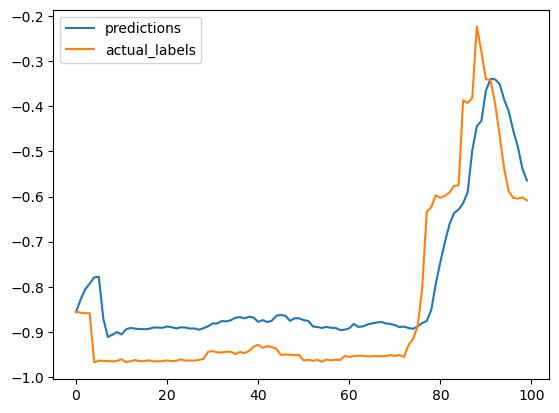

In [92]:
result_df[:100].plot()

### MSE

In [93]:
from torchmetrics.regression import MeanSquaredError

In [94]:
mse = MeanSquaredError()
mse(torch.tensor(result_df['predictions'].values), torch.tensor(result_df['actual_labels'].values))

tensor(0.0140)